# Synthetic data test: Different structural indices

In this test, we'll create data from different sources and try running the inversion on each source with different SI values. We'll plot the estimated depths and the weights RMSE to see if there is a difference in data misfit when using the wrong SI value.

In [1]:
from pathlib import Path
import numpy as np
from IPython.display import Image
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
region = [0, 35e3, 0, 25e3]
coordinates = vd.grid_coordinates(region, spacing=300, extra_coords=1000)
inclination, declination = 35, -20
base_level = 300
noise_level = 10
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
true_coordinates = (15e3, 10e3, 0e3)

Gather all data into a dictionary for later use. For each model, we'll generate a grid of total-field anomaly and the 3 spatial derivatives. Horizontal derivatives are calculated with finite-differences and the vertical derivated with FFT.

In [4]:
datasets = {}

### Dipole

Data from single dipole.

In [5]:
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(1e10, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(
    0, noise_level, size=magnetic_anomaly.shape
)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(
    coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"]
)
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

datasets["dipole"] = data

### Pipe

A vertical pipe, approximated by a prism with very small dimensions and elongated in depth.

In [6]:
size = 50
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        true_coordinates[0] - size,
        true_coordinates[0] + size,
        true_coordinates[1] - size,
        true_coordinates[1] + size,
        true_coordinates[2] - 15e3,
        true_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(1500, 90, 0),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(
    0, noise_level, size=magnetic_anomaly.shape
)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(
    coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"]
)
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

datasets["pipe"] = data

### Dike

A dike, approximated by a thin prism along the northing direction.

In [7]:
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        true_coordinates[0] - 100,
        true_coordinates[0] + 100,
        true_coordinates[1] - 50e3,
        true_coordinates[1] + 50e3,
        true_coordinates[2] - 7e3,
        true_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(40, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(
    0, noise_level, size=magnetic_anomaly.shape
)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(
    coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"]
)
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

datasets["dike"] = data

### Line

A thin horizontal line that terminates in the center of the image.

In [8]:
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        true_coordinates[0] - 50,
        true_coordinates[0] + 50,
        true_coordinates[1] - 50e3,
        true_coordinates[1],
        true_coordinates[2] - 50,
        true_coordinates[2] + 50,
    ],
    magnetization=hm.magnetic_angles_to_vec(1000, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(
    0, noise_level, size=magnetic_anomaly.shape
)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(
    coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"]
)
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

datasets["line"] = data

## Plot the data

Make a maps of the data generated for visual inspection.

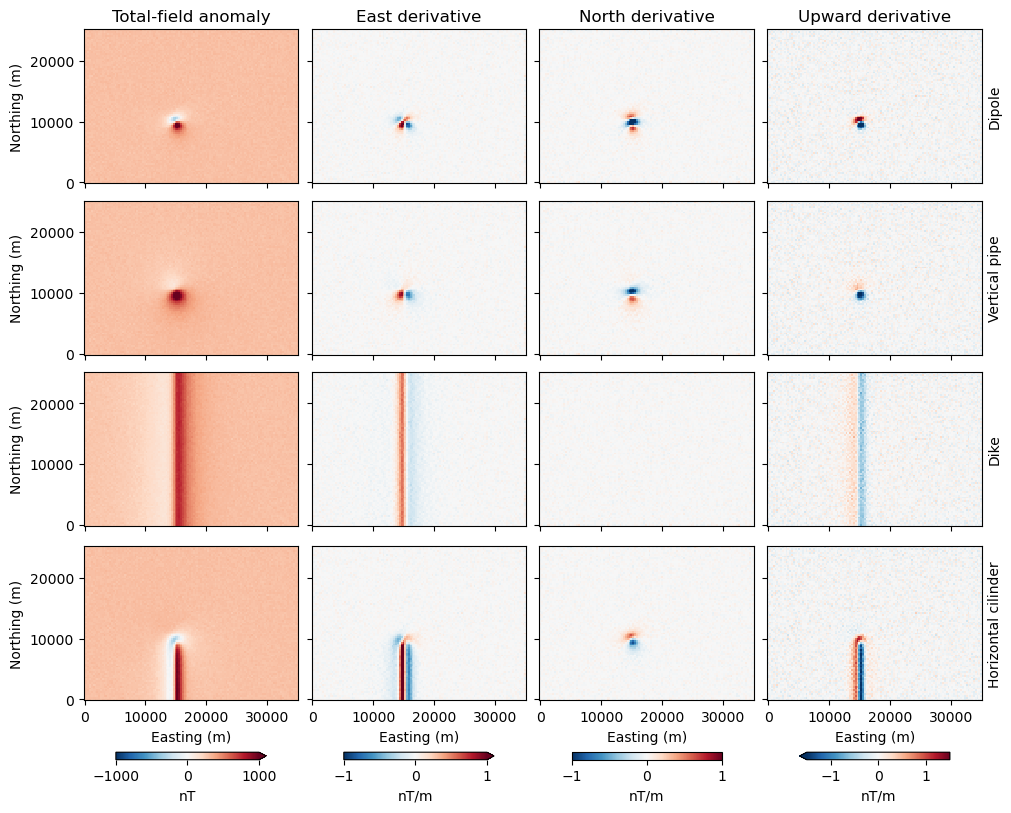

In [9]:
model_names = {
    "dipole": "Dipole",
    "line": "Horizontal cilinder",
    "pipe": "Vertical pipe",
    "dike": "Dike",
}
units = {"field": "nT", "deriv_east": "nT/m", "deriv_north": "nT/m", "deriv_up": "nT/m"}
scale = {"field": 1000, "deriv_east": 1, "deriv_north": 1, "deriv_up": 1.5}
titles = {
    "field": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}

fig, axes = plt.subplots(
    4, 4, figsize=(10, 8), layout="constrained", sharex=True, sharey=True
)
for i, model in enumerate(datasets):
    for field, ax in zip(titles, axes[i, :].ravel()):
        if i == axes.shape[0] - 1:
            kwargs = dict(
                add_colorbar=True,
                cbar_kwargs=dict(
                    orientation="horizontal", aspect=20, shrink=0.7, label=units[field]
                ),
            )
        else:
            kwargs = dict(add_colorbar=False)
        datasets[model][field].plot.pcolormesh(
            ax=ax,
            add_labels=False,
            cmap="RdBu_r",
            vmin=-scale[field],
            vmax=scale[field],
            **kwargs
        )
        ax.set_aspect("equal")
for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[-1, :]:
    ax.set_xlabel("Easting (m)")
for ax, model in zip(axes[:, -1], datasets):
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(model_names[model])
for ax, field in zip(axes[0, :], titles):
    ax.set_title(titles[field])
plt.show()

## Run the Euler Inversion

Now we can run the Euler inversion on all 4 datasets. For each model, we'll the inversion 3 times varying the SI value. We'll report the estimated position (true z coordinate is 0 m) and the weighted RMSE.

In [10]:
structural_indices = [1, 2, 3]
rmse = {}
solutions = {}
for model in ["dipole", "line", "pipe", "dike"]:
    print(f"{model.capitalize()}:")
    data = datasets[model]
    rmse[model] = []
    solutions[model] = []
    for si in structural_indices:
        ei = euler.EulerInversion(structural_index=si).fit_grid(data)
        solutions[model].append(ei)
        rmse[model].append(ei.data_misfit_[-1])
        print(f"  SI={si} | RMSE={rmse[model][-1]} | Position={ei.location_}")

Dipole:
  SI=1 | RMSE=0.3297944132846975 | Position=[15026.44062434 10033.64084668   645.829773  ]
  SI=2 | RMSE=0.2618884280778848 | Position=[14999.86447433 10007.54461774   330.47704751]
  SI=3 | RMSE=0.2519421464877733 | Position=[15000.05799137  9997.83980371   -23.16587399]
Line:
  SI=1 | RMSE=0.2734785910489844 | Position=[15039.85063165 10051.18961505   461.89075959]
  SI=2 | RMSE=0.25449134413115637 | Position=[1.50016154e+04 9.98720645e+03 5.31144183e+00]
  SI=3 | RMSE=0.27091202978599793 | Position=[15001.04821755  9991.52303603  -484.89804326]
Pipe:
  SI=1 | RMSE=0.2837862960270558 | Position=[15046.52447799 10087.87247858   520.38473534]
  SI=2 | RMSE=0.25417794840253843 | Position=[1.49990623e+04 9.99022172e+03 8.06166482e+00]
  SI=3 | RMSE=0.2726577232840765 | Position=[15002.82294017  9982.46253106  -593.71157763]
Dike:
  SI=1 | RMSE=0.2595009735961621 | Position=[15006.2008234  12578.79677331   111.76310401]
  SI=2 | RMSE=0.2824604706228784 | Position=[15006.26164887 1

Seems like there is a pattern: 

1. z correlates with SI just like Euler deconvolution
2. RMSE is smallest for the correct SI

## Make a figure for the paper

Now we can make a figure for the paper that summarizes these results.

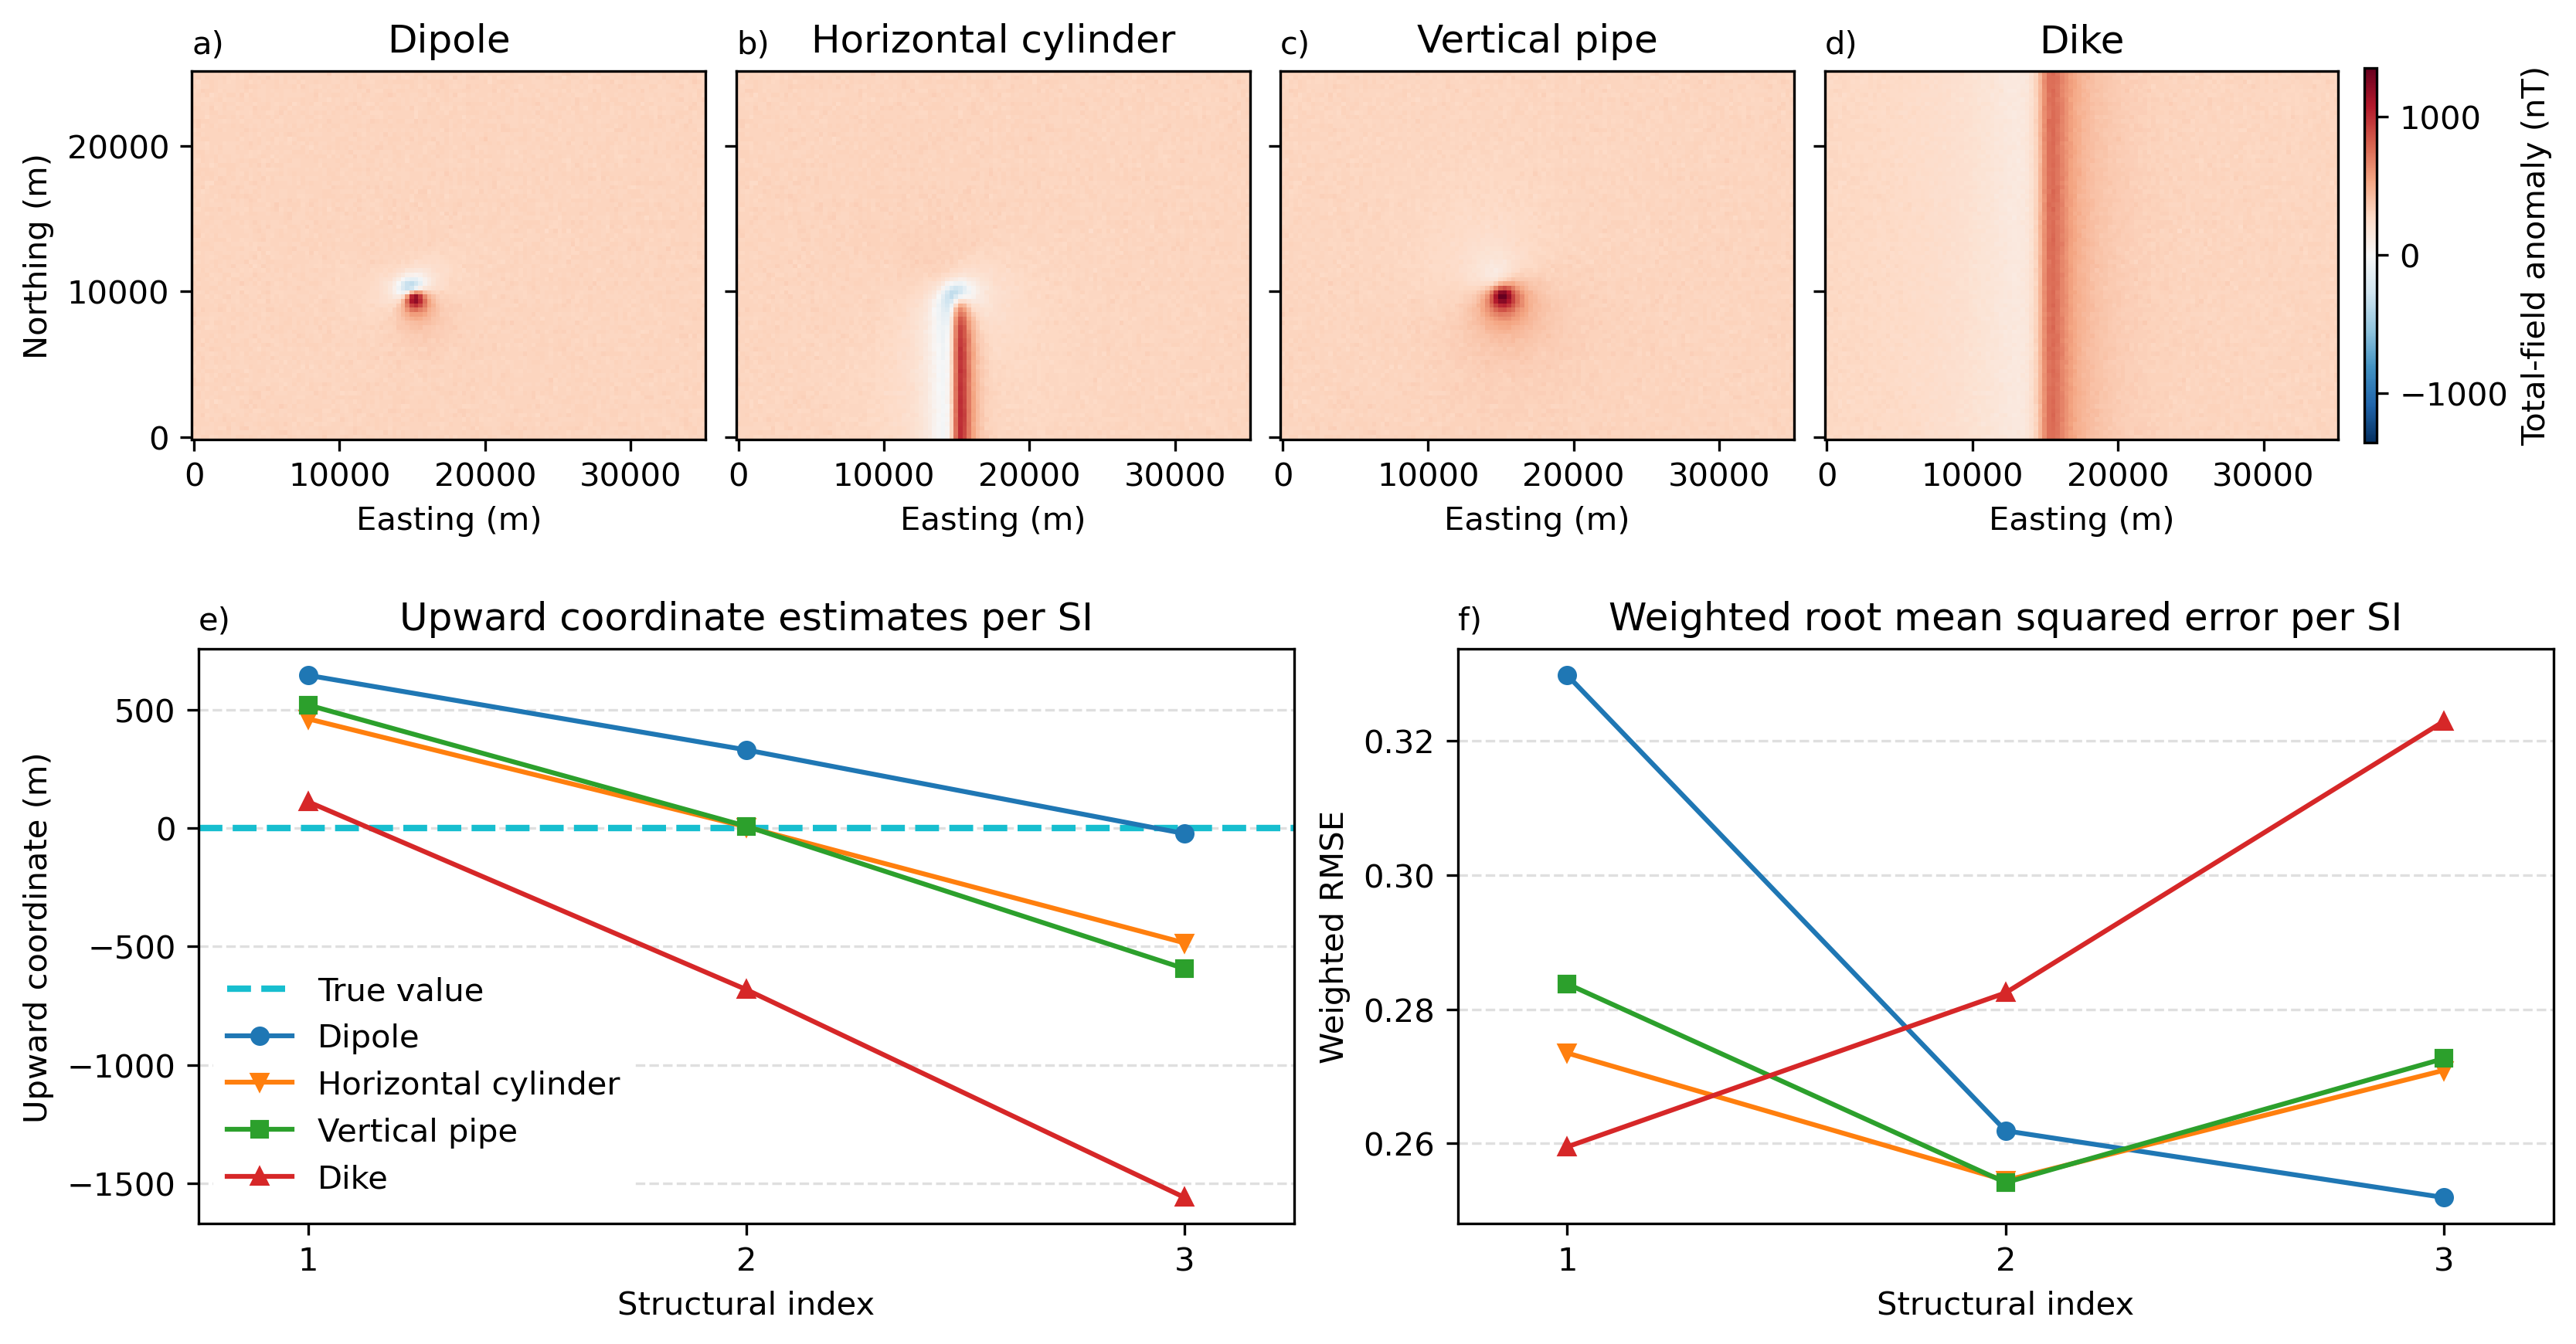

In [11]:
fig = plt.figure(figsize=(11, 5.6), layout="constrained")
figures = fig.subfigures(2, 1, height_ratios=(1, 1.5), hspace=0.1)

axes = figures[0].subplots(1, 4, sharey=True)
model_names = {
    "dipole": "Dipole",
    "line": "Horizontal cylinder",
    "pipe": "Vertical pipe",
    "dike": "Dike",
}
scale = vd.maxabs([datasets[model].field.values for model in datasets])
for ax, model, label in zip(axes, model_names, "abcd"):
    ax.set_aspect("equal")
    tmp = datasets[model].field.plot.pcolormesh(
        ax=ax,
        add_labels=False,
        add_colorbar=False,
        cmap="RdBu_r",
        vmin=-scale,
        vmax=scale,
    )
    ax.set_title(model_names[model])
    ax.set_xlabel("Easting (m)")
    ax.text(0, 1.05, f"{label})", transform=ax.transAxes)
figures[0].colorbar(tmp, ax=axes[-1], aspect=30, label="Total-field anomaly (nT)")
axes[0].set_ylabel("Northing (m)")

colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
markers = ["o", "v", "s", "^"]

xlim = 0.75, 3.25

axes = figures[1].subplots(1, 2)
ax = axes[0]
ax.hlines(
    0, *xlim, colors=colors[-1], linestyles="--", linewidths=2, label="True value"
)
for model, color, marker in zip(solutions, colors, markers):
    z = [ei.location_[-1] for ei in solutions[model]]
    ax.plot(
        structural_indices,
        z,
        color=color,
        marker=marker,
        label=model_names[model],
        markersize=5,
    )
ax.set_xlabel("Structural index")
ax.set_xlim(*xlim)
ax.set_xticks([1, 2, 3])
ax.set_ylabel("Upward coordinate (m)")
ax.set_title("Upward coordinate estimates per SI")
ax.legend(
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
)
ax.text(0, 1.035, "e)", transform=ax.transAxes)
ax.grid(axis="y", alpha=0.4, linestyle="--")

ax = axes[1]
for model, color, marker in zip(rmse, colors, markers):
    ax.plot(
        structural_indices,
        rmse[model],
        color=color,
        marker=marker,
        label=model_names[model],
        markersize=5,
    )
ax.set_xlabel("Structural index")
ax.set_xlim(0.75, 3.25)
ax.set_xticks([1, 2, 3])
ax.set_ylabel("Weighted RMSE")
ax.set_title("Weighted root mean squared error per SI")
ax.text(0, 1.035, "f)", transform=ax.transAxes)
ax.grid(axis="y", alpha=0.4, linestyle="--")

# Save the figure and display the saved figure because savefig and
# show can sometimes create slightly different figures
figfile = Path("..") / "paper" / "figures" / "synthetic-structural-index.png"
fig.savefig(figfile, dpi=300, bbox_inches="tight")
plt.close()
Image(figfile)